Test the CNN Multigrid on a model problem: f(x,y) = 0

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import time

import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt

from FEANet.mesh import MeshSquare
from FEANet.geo import Geometry
from FEANet.jacobi import JacobiBlock
from FEANet.model import KNet, FNet
from Utils import plot

In [2]:
class SingleGrid():
    '''
    Perform weighted Jacobi iteration relaxation for a single grid.
    Note: the n should be the number of intervals, e.g., 
          there are (n+1)*(n+1) grid points in total if the size is n
          f has already been convoluted, i.e., f = fnet(ff) if ff is the sourcing term of PDE
    '''
    def __init__(self, size, n):
        self.size = size # actual size of the plate
        self.n = n 
        self.omega = 2/3.
        self.plate = Geometry(nnode_edge = n+1)
        self.grid = MeshSquare(size, nnode_edge=n+1)
        self.v = torch.zeros((1, 1, n+1, n+1), requires_grad=False, dtype=torch.float32)
        self.f = torch.zeros((1, 1, n+1, n+1), requires_grad=False, dtype=torch.float32)
        self.InstantiateFEANet()
        self.jac = JacobiBlock(self.Knet, self.grid, self.omega, self.plate.geometry_idx, self.plate.boundary_value)

    def IsCoarsest(self):
        return self.n == 2
        
    def InstantiateFEANet(self):
        self.Knet = KNet(self.grid) # Initialize the stiffness network, given mesh
        self.fnet = FNet(self.size/self.n) # Initialize the forcing term network, given mesh size
        for param in self.Knet.parameters():
            param.requires_grad = False
        for param in self.fnet.parameters():
            param.requires_grad = False

    def Relax(self, num_sweeps_down):
        '''
        Perform a fixed number of weighted Jacobi iteration
        '''
        for _ in range(num_sweeps_down):
            self.v = self.jac.jacobi_convolution(self.v, self.f)


In [3]:
class Multigrid():
    '''Define the multigrid problem for 2D, n is the finest grid size'''
    def __init__(self, n = 64, final_level = None):
        self.size = 2
        self.n = n # total number of grids for finest grid
        if(final_level is None):
            self.L = int(np.log2(n)) # number of levels for V-cycle multigrid
        else:
            self.L = final_level

        self.n_arr = self.SizeArray() # array to store grid size for each level
        self.grids = self.GridDict() # dictionary of structure grids
        
        self.initial_v = torch.from_numpy(self.random_data())
        self.grids[0].f =  torch.zeros((1, 1, n+1, n+1), requires_grad=False, dtype=torch.float32)

    def GridDict(self):
        grids = {}
        for i in range(self.L):
            grids[i] = SingleGrid(self.size, self.n_arr[i])
        return grids

    def SizeArray(self):
        n_arr = []
        for i in range(self.L):
            n_arr.append(int(self.n/(2.**i)))
        n_arr = np.array(n_arr)
        return n_arr

    def Restrict(self, f):
        '''
        Perform full weighting operation to down sample to next level
        '''
        f_res = f[:, :, 1:-1, 1:-1]
        restriction_kernel = torch.asarray([[1, 2, 1],
                                            [2, 4, 2],
                                            [1, 2, 1]], dtype=torch.float32) / 16.0

        f_res = F.conv2d(f_res, restriction_kernel.view(1, 1, 3, 3), stride=2)
        return F.pad(f_res,(1,1,1,1),"constant",0) # pad with zeros

    def Interpolate(self, v):
        '''
        Perform linear interpolation and upsample to previous level ==> Return size: (2*N - 1), Ex. 17 -> 33
        '''
        _, _, image_size, _ = v.shape
        new_size = 2 * image_size - 1
        v = F.interpolate(v, size=new_size, mode='bilinear', align_corners=True)
        level = np.where(self.n_arr == new_size-1)[0][0]
        return self.grids[level].jac.reset_boundary(v)
    
    def rec_V_cycle(self, l, v, f):
        '''
        Perform recursive V-cycle
        Input: l, current level
        '''
        self.grids[l].v = v
        self.grids[l].f = f
        self.grids[l].Relax(self.v1)
        if(l < self.L-1):
            residual = self.grids[l].f-self.grids[l].Knet(self.grids[l].v)
            self.grids[l+1].f = 4*self.Restrict(residual)
            self.grids[l+1].v *= 0.
            self.rec_V_cycle(l+1, self.grids[l+1].v, self.grids[l+1].f)
            self.grids[l].v += self.Interpolate(self.grids[l+1].v)
            self.grids[l+1].v *= 0.
        
        self.grids[l].Relax(self.v2) 

    def V_cycle(self, x, f):
        '''Input x is the initial solution on the finest grid'''
        n_batches = x.shape[0]
        self.grids[0].v = x
        self.grids[0].f = f
        
        for j in range(0, self.L-1):
            self.grids[j].Relax(self.v1)
            print(self.grids[j].v.shape)
            rF = self.grids[j].f-self.grids[j].Knet(self.grids[j].v)
            self.grids[j+1].f = 4*self.Restrict(rF)
            self.grids[j+1].v *= 0.

        self.grids[self.L-1].Relax(self.v1+self.v2)

        for j in range(self.L-2,-1,-1):
            eFC = self.grids[j+1].v
            eF_delta = self.Interpolate(eFC)
            self.grids[j].v = self.grids[j].v + eF_delta
            self.grids[j].Relax(self.v2)

            # zero out the previous level solution
            self.grids[j+1].v *= 0. 

    def random_data(self):
        #np.random.seed(123)
        coef = 100000 + 50000*np.random.rand(2)
        return coef[0]*np.random.random((self.n+1,self.n+1)).astype('f') + coef[1]

    def Solve(self, v1v2=[1,1], rec = True, n_iter=None, EPS=None):        
        if (n_iter is None):
            if(EPS is None):
                print("At least one of EPS and n_iter have to be assigned")
                return # 
            else:
                n_iter = 0
        else:
            if(EPS is None):
                EPS = np.inf

        n_Vcycle = 0
        res = 1
        res_arr_Vcycle = []

        self.v1, self.v2 = v1v2
        self.grids[0].v = self.initial_v.reshape(1,1,self.n+1,self.n+1)
        while (res > EPS or n_Vcycle < n_iter):
            u_prev = self.grids[0].v 
            if(rec is True):
                self.rec_V_cycle(0,self.grids[0].v,self.grids[0].f)
            else:
                self.V_cycle(self.grids[0].v,self.grids[0].f)
            residual = self.grids[0].f-self.grids[0].Knet(self.grids[0].v)
            res = torch.sqrt(torch.sum(residual[:, :, 1:-1, 1:-1] ** 2)).item()
            res_arr_Vcycle.append(res)
            #print(n_Vcycle, res)
            n_Vcycle += 1

        #print("Solution converges after", n_Vcycle, "V-cycle iterations")
        return res_arr_Vcycle

    def solve_jacobi(self, n_iter=None, EPS=None):
        if (n_iter is None):
            if(EPS is None):
                print("At least one of EPS and n_iter have to be assigned")
                return # 
            else:
                n_iter = 0
        else:
            if(EPS is None):
                EPS = np.inf

        n_jacobi = 0
        self.grids[0].v = self.initial_v
        res_arr_jacobi = []
        res = 1
        while (res > EPS or n_jacobi < n_iter):
            self.grids[0].Relax(1)
            residual = self.grids[0].f-self.grids[0].Knet(self.grids[0].v)
            res = torch.sqrt(torch.sum(residual[:, :, 1:-1, 1:-1] ** 2)).item()
            res_arr_jacobi.append(res)
            #print(res)
            n_jacobi += 1

        #print("Solution converges after", n_jacobi, "Weighted Jacobi iterations")
        return res_arr_jacobi

In [4]:
def compute_q(res_arr, m = None):
    if(m is None):
        return res_arr[-1]/res_arr[-2]
    else:
        return res_arr[m]/res_arr[m-1]

In [5]:
# test the convergence factor when change the grid size
size_list = [1,2,3,4,5,6,7,8,9]
for size in size_list:
    n = 2**size
    prob_mg = Multigrid(n)

    start = time.time()
    res_vcycle = prob_mg.Solve([1,1], EPS=1e-6)
    end = time.time()
    print("Convergence factor for n=2^" + str(size)+ " is:", compute_q(res_vcycle), ', time =', end-start, 'second')

Convergence factor for n=2^1 is: 0.11111110105447959 , time = 0.003339529037475586 second
Convergence factor for n=2^2 is: 0.20320289267157887 , time = 0.008211851119995117 second
Convergence factor for n=2^3 is: 0.22705374241213908 , time = 0.015706300735473633 second
Convergence factor for n=2^4 is: 0.23623111562228755 , time = 0.029912710189819336 second
Convergence factor for n=2^5 is: 0.2521629576411248 , time = 0.03536033630371094 second
Convergence factor for n=2^6 is: 0.25900978515692 , time = 0.03717803955078125 second
Convergence factor for n=2^7 is: 0.26230444531364716 , time = 0.05929279327392578 second
Convergence factor for n=2^8 is: 0.26295500430251095 , time = 0.12586736679077148 second
Convergence factor for n=2^9 is: 0.26316125814795244 , time = 0.42643189430236816 second


In [6]:
# test the convergence factor when change the grid size (jacobi itaration)
size_list = [1,2,3,4,5,6,7,8,9]
for size in size_list:
    n = 2**size
    prob_jac = Multigrid(n)
    start = time.time()
    if (size < 5):
        res_jacobi = prob_jac.solve_jacobi(EPS=1e-5)
    else:
        res_jacobi = prob_jac.solve_jacobi(n_iter=2000)
    end = time.time()
    print("Convergence factor for n=2^" + str(size)+ " is:", compute_q(res_jacobi), ', time =', end-start, 'second')

Convergence factor for n=2^1 is: 0.33333329777930615 , time = 0.003079652786254883 second
Convergence factor for n=2^2 is: 0.7357023129437866 , time = 0.012391328811645508 second
Convergence factor for n=2^3 is: 0.9258110664371474 , time = 0.043920278549194336 second
Convergence factor for n=2^4 is: 0.9809080721911905 , time = 0.19424200057983398 second
Convergence factor for n=2^5 is: 0.995192224076603 , time = 0.29528355598449707 second
Convergence factor for n=2^6 is: 0.9987957479351752 , time = 0.383054256439209 second
Convergence factor for n=2^7 is: 0.9996457255615815 , time = 0.5610854625701904 second
Convergence factor for n=2^8 is: 0.9996247757202597 , time = 1.8861982822418213 second
Convergence factor for n=2^9 is: 0.9996240861278665 , time = 8.527746200561523 second


In [7]:
# Multigrid implementation
n = 2**6
prob_mg = Multigrid(n)

In [8]:
#res_vcycle_v01 = prob_mg.Solve([0,1], EPS=1e-6)

#plt.plot(res_vcycle_v01, label='Residual')
#plt.yscale('log')
#plt.xlabel('# iteration')
#plt.legend()

#print("Convergence factor is:", compute_q(res_vcycle_v01))

Convergence factor is: 0.4940849938396586
Time cost: 0.06909537315368652


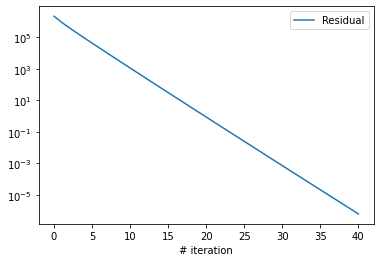

In [9]:
start = time.time()
res_arr_v01 = prob_mg.Solve([0,1], EPS=1e-6)
end = time.time()

plt.plot(res_arr_v01, label='Residual')
plt.yscale('log')
plt.xlabel('# iteration')
plt.legend()

print("Convergence factor is:", compute_q(res_arr_v01))
print("Time cost:", end-start)

Convergence factor is: 0.26061844227777586
Time cost: 0.05902218818664551


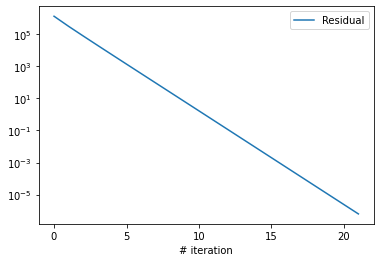

In [10]:
start = time.time()
res_arr_v02 = prob_mg.Solve([0,2], EPS=1e-6)
end = time.time()

plt.plot(res_arr_v02, label='Residual')
plt.yscale('log')
plt.xlabel('# iteration')
plt.legend()

print("Convergence factor is:", compute_q(res_arr_v02))
print("Time cost:", end-start)

Convergence factor is: 0.4915057779145805
Time cost: 0.060013771057128906


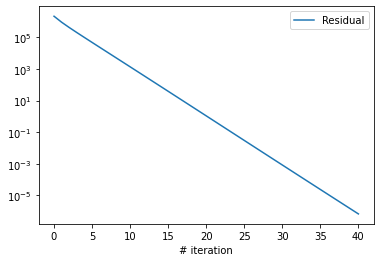

In [11]:
start = time.time()
res_arr_v10 = prob_mg.Solve([1,0], EPS=1e-6)
end = time.time()

plt.plot(res_arr_v10, label='Residual')
plt.yscale('log')
plt.xlabel('# iteration')
plt.legend()

print("Convergence factor is:", compute_q(res_arr_v10))
print("Time cost:", end-start)

Convergence factor is: 0.2591727916887402
Time cost: 0.053819894790649414


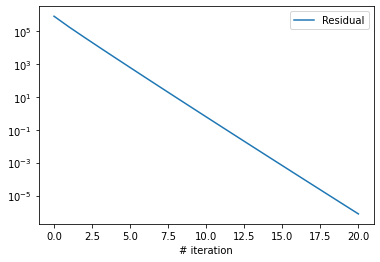

In [12]:
start = time.time()
res_arr_v11 = prob_mg.Solve([1,1], EPS=1e-6)
end = time.time()

plt.plot(res_arr_v11, label='Residual')
plt.yscale('log')
plt.xlabel('# iteration')
plt.legend()

print("Convergence factor is:", compute_q(res_arr_v11))
print("Time cost:", end-start)

Convergence factor is: 0.15967152847728747
Time cost: 0.03984832763671875


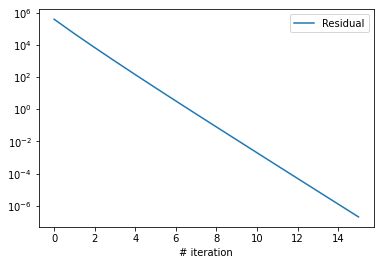

In [13]:
start = time.time()
res_arr_v12 = prob_mg.Solve([1,2], EPS=1e-6)
end = time.time()

plt.plot(res_arr_v12, label='Residual')
plt.yscale('log')
plt.xlabel('# iteration')
plt.legend()

print("Convergence factor is:", compute_q(res_arr_v12))
print("Time cost:", end-start)

Convergence factor is: 0.2586989460491826
Time cost: 0.07971978187561035


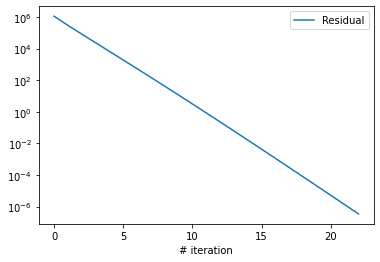

In [14]:
start = time.time()
res_arr_v20 = prob_mg.Solve([2,0], EPS=1e-6)
end = time.time()

plt.plot(res_arr_v20, label='Residual')
plt.yscale('log')
plt.xlabel('# iteration')
plt.legend()

print("Convergence factor is:", compute_q(res_arr_v20))
print("Time cost:", end-start)

Convergence factor is: 0.1604296643000581
Time cost: 0.03870034217834473


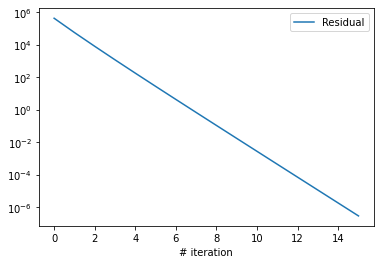

In [15]:
start = time.time()
res_arr_v21 = prob_mg.Solve([2,1], EPS=1e-6)
end = time.time()

plt.plot(res_arr_v21, label='Residual')
plt.yscale('log')
plt.xlabel('# iteration')
plt.legend()

print("Convergence factor is:", compute_q(res_arr_v21))
print("Time cost:", end-start)

Convergence factor is: 0.1126845670804337
Time cost: 0.041115760803222656


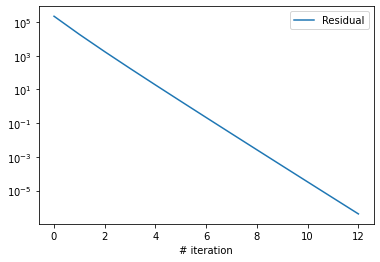

In [16]:
start = time.time()
res_arr_v22 = prob_mg.Solve([2,2], EPS=1e-6)
end = time.time()

plt.plot(res_arr_v22, label='Residual')
plt.yscale('log')
plt.xlabel('# iteration')
plt.legend()

print("Convergence factor is:", compute_q(res_arr_v22))
print("Time cost:", end-start)

torch.Size([1, 1, 65, 65])
torch.Size([1, 1, 33, 33])
torch.Size([1, 1, 17, 17])
torch.Size([1, 1, 9, 9])
torch.Size([1, 1, 5, 5])
torch.Size([1, 1, 65, 65])
torch.Size([1, 1, 33, 33])
torch.Size([1, 1, 17, 17])
torch.Size([1, 1, 9, 9])
torch.Size([1, 1, 5, 5])
torch.Size([1, 1, 65, 65])
torch.Size([1, 1, 33, 33])
torch.Size([1, 1, 17, 17])
torch.Size([1, 1, 9, 9])
torch.Size([1, 1, 5, 5])
torch.Size([1, 1, 65, 65])
torch.Size([1, 1, 33, 33])
torch.Size([1, 1, 17, 17])
torch.Size([1, 1, 9, 9])
torch.Size([1, 1, 5, 5])
torch.Size([1, 1, 65, 65])
torch.Size([1, 1, 33, 33])
torch.Size([1, 1, 17, 17])
torch.Size([1, 1, 9, 9])
torch.Size([1, 1, 5, 5])
torch.Size([1, 1, 65, 65])
torch.Size([1, 1, 33, 33])
torch.Size([1, 1, 17, 17])
torch.Size([1, 1, 9, 9])
torch.Size([1, 1, 5, 5])
torch.Size([1, 1, 65, 65])
torch.Size([1, 1, 33, 33])
torch.Size([1, 1, 17, 17])
torch.Size([1, 1, 9, 9])
torch.Size([1, 1, 5, 5])
torch.Size([1, 1, 65, 65])
torch.Size([1, 1, 33, 33])
torch.Size([1, 1, 17, 17])
to

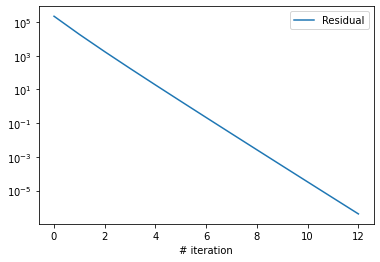

In [17]:
res_vcycle_v22 = prob_mg.Solve([2,2], rec = False, EPS=1e-6)

plt.plot(res_vcycle_v22, label='Residual')
plt.yscale('log')
plt.xlabel('# iteration')
plt.legend()

print("Convergence factor is:", compute_q(res_vcycle_v22))

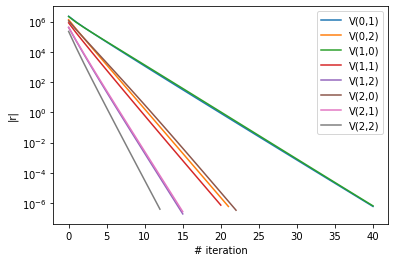

In [20]:
plt.plot(res_arr_v01, label='V(0,1)')
plt.plot(res_arr_v02, label='V(0,2)')
plt.plot(res_arr_v10, label='V(1,0)')
plt.plot(res_arr_v11, label='V(1,1)')
plt.plot(res_arr_v12, label='V(1,2)')
plt.plot(res_arr_v20, label='V(2,0)')
plt.plot(res_arr_v21, label='V(2,1)')
plt.plot(res_arr_v22, label='V(2,2)')
plt.yscale('log')
plt.xlabel('# iteration')
plt.ylabel('|r|')
plt.legend()
plt.savefig('Results/poisson_convergence.jpg', dpi=500, bbox_inches='tight')